In [315]:
import os
import pickle
import numpy as np
import cv2
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from sklearn.preprocessing import Normalizer
from pickle import load
import matplotlib.pyplot as plt
# from utils import get_face, get_encode, l2_normalizer, normalize

In [316]:
def get_encode(model, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = model.predict(np.expand_dims(face, axis=0))[0]
    return encode

In [317]:
def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

In [318]:
l2_normalizer = Normalizer('l2')
r_t = 0.3

In [319]:
def normalize(img):
    mean, std = img.mean(), img.std()
    return (img - mean) / std

In [320]:
model = load_model('facenet_keras.h5')

c:\users\shlok\anaconda3\envs\yolo\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [321]:
model.inputs
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_

Block35_4_Branch_2_Conv2d_0a_1x (None, 17, 17, 32)   8192        Block35_3_Activation[0][0]       
__________________________________________________________________________________________________
Block35_4_Branch_2_Conv2d_0a_1x (None, 17, 17, 32)   96          Block35_4_Branch_2_Conv2d_0a_1x1[
__________________________________________________________________________________________________
Block35_4_Branch_2_Conv2d_0a_1x (None, 17, 17, 32)   0           Block35_4_Branch_2_Conv2d_0a_1x1_
__________________________________________________________________________________________________
Block35_4_Branch_1_Conv2d_0a_1x (None, 17, 17, 32)   8192        Block35_3_Activation[0][0]       
__________________________________________________________________________________________________
Block35_4_Branch_2_Conv2d_0b_3x (None, 17, 17, 32)   9216        Block35_4_Branch_2_Conv2d_0a_1x1_
__________________________________________________________________________________________________
Block35_4_

Block17_6_ScaleSum (Lambda)     (None, 8, 8, 896)    0           Block17_5_Activation[0][0]       
                                                                 Block17_6_Conv2d_1x1[0][0]       
__________________________________________________________________________________________________
Block17_6_Activation (Activatio (None, 8, 8, 896)    0           Block17_6_ScaleSum[0][0]         
__________________________________________________________________________________________________
Block17_7_Branch_1_Conv2d_0a_1x (None, 8, 8, 128)    114688      Block17_6_Activation[0][0]       
__________________________________________________________________________________________________
Block17_7_Branch_1_Conv2d_0a_1x (None, 8, 8, 128)    384         Block17_7_Branch_1_Conv2d_0a_1x1[
__________________________________________________________________________________________________
Block17_7_Branch_1_Conv2d_0a_1x (None, 8, 8, 128)    0           Block17_7_Branch_1_Conv2d_0a_1x1_
__________

__________________________________________________________________________________________________
Block8_4_Branch_1_Conv2d_0a_1x1 (None, 3, 3, 192)    0           Block8_4_Branch_1_Conv2d_0a_1x1_B
__________________________________________________________________________________________________
Block8_4_Branch_1_Conv2d_0b_1x3 (None, 3, 3, 192)    110592      Block8_4_Branch_1_Conv2d_0a_1x1_A
__________________________________________________________________________________________________
Block8_4_Branch_1_Conv2d_0b_1x3 (None, 3, 3, 192)    576         Block8_4_Branch_1_Conv2d_0b_1x3[0
__________________________________________________________________________________________________
Block8_4_Branch_1_Conv2d_0b_1x3 (None, 3, 3, 192)    0           Block8_4_Branch_1_Conv2d_0b_1x3_B
__________________________________________________________________________________________________
Block8_4_Branch_0_Conv2d_1x1 (C (None, 3, 3, 192)    344064      Block8_3_Activation[0][0]        
__________

In [322]:
train_path = 'data/'

In [323]:
detector = MTCNN()

In [324]:
database = {}
required_size = (160, 160)

In [325]:
for name in os.listdir(train_path):
    person_path = os.path.join(train_path,name)
    encodes = []
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(img_rgb)
        if results:
            res = max(results, key=lambda b: b['box'][2] * b['box'][3])
            face, _, _ = get_face(img_rgb, res['box'])

            face = normalize(face)
            face = cv2.resize(face, required_size)
            encode = model.predict(np.expand_dims(face, axis=0))[0]
            encodes.append(encode)
    if encodes:
        encode = np.sum(encodes, axis=0)
        encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]
        database[name] = encode

In [326]:
print(os.listdir(train_path))

['Andrew Ng', 'Bill Gates', 'Elon Musk']


In [327]:
for key in database.keys():
    print(key)


Andrew Ng
Bill Gates
Elon Musk


In [328]:
pickle.dump(database,open('encodings.pkl','wb'))


In [329]:
from scipy.spatial.distance import cosine

In [353]:
test_path = 'data/Andrew Ng/1.jfif'
img = cv2.imread(test_path)
img

array([[[162, 188, 175],
        [162, 188, 175],
        [162, 188, 175],
        ...,
        [132, 154, 149],
        [131, 153, 148],
        [130, 152, 147]],

       [[162, 188, 175],
        [161, 187, 174],
        [161, 187, 174],
        ...,
        [133, 155, 150],
        [132, 154, 149],
        [131, 153, 148]],

       [[162, 186, 174],
        [162, 186, 174],
        [161, 185, 173],
        ...,
        [135, 157, 152],
        [134, 156, 151],
        [134, 156, 151]],

       ...,

       [[181, 128, 108],
        [180, 127, 107],
        [182, 129, 109],
        ...,
        [255, 253, 248],
        [255, 255, 252],
        [255, 255, 252]],

       [[169, 116,  96],
        [168, 115,  95],
        [171, 118,  98],
        ...,
        [255, 252, 249],
        [255, 255, 254],
        [255, 255, 254]],

       [[162, 109,  89],
        [161, 108,  88],
        [164, 111,  91],
        ...,
        [255, 252, 249],
        [255, 255, 254],
        [255, 255, 254]]

In [362]:
database = load(open('encodings.pkl', 'rb'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = detector.detect_faces(img_rgb)

In [363]:
for res in results:
    face, pt_1, pt_2 = get_face(img_rgb, res['box'])
    encode = get_encode(model, face, required_size)
    encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]

    name = 'unknown'
    distance = float("inf")

    for db_name, db_encode in database.items():
        dist = cosine(db_encode, encode)
        if dist < r_t and dist < distance:
            name = db_name
            distance = dist
    if name == 'unknown':
        cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
        cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
    else:
        cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
        cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 2)


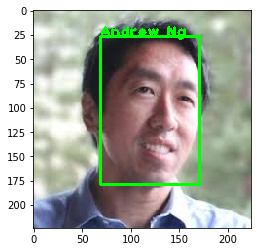

In [356]:
def plt_show(cv_img):
    img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
plt_show(img)

In [357]:
test_path = 'test/2.jfif'
img = cv2.imread(test_path)
img

array([[[205, 204, 206],
        [209, 208, 210],
        [214, 213, 215],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[205, 204, 206],
        [208, 207, 209],
        [214, 213, 215],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[204, 203, 205],
        [208, 207, 209],
        [214, 213, 215],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 47,  43,  49],
        [ 39,  37,  43],
        [ 44,  42,  48],
        ...,
        [ 13,  11,  11],
        [ 13,  11,  11],
        [ 14,  12,  12]],

       [[ 47,  43,  49],
        [ 39,  37,  43],
        [ 44,  42,  48],
        ...,
        [ 10,   8,   8],
        [ 10,   8,   8],
        [ 10,   8,   8]],

       [[ 47,  43,  49],
        [ 39,  37,  43],
        [ 44,  42,  48],
        ...,
        [  8,   6,   6],
        [  7,   5,   5],
        [  6,   4,   4]]

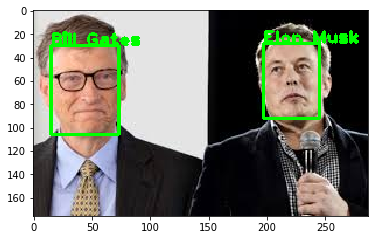

In [360]:
def plt_show(cv_img):
    img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
plt_show(img)

In [361]:
test_path = 'test/3.jfif'
img = cv2.imread(test_path)
img

array([[[ 57, 105,  93],
        [ 57, 105,  93],
        [ 61, 107,  95],
        ...,
        [ 32,  34,  35],
        [ 34,  36,  37],
        [ 34,  36,  37]],

       [[ 56, 104,  92],
        [ 55, 103,  91],
        [ 58, 104,  92],
        ...,
        [ 33,  35,  36],
        [ 34,  36,  37],
        [ 34,  36,  37]],

       [[ 58, 104,  91],
        [ 57, 103,  90],
        [ 59, 103,  90],
        ...,
        [ 34,  36,  37],
        [ 32,  34,  35],
        [ 32,  34,  35]],

       ...,

       [[ 71, 109,  87],
        [ 72, 110,  88],
        [ 73, 111,  89],
        ...,
        [ 17,  12,  13],
        [ 16,  11,  12],
        [ 17,  12,  13]],

       [[ 70, 108,  86],
        [ 72, 110,  88],
        [ 73, 111,  89],
        ...,
        [ 16,  11,  12],
        [ 17,  12,  13],
        [ 18,  13,  14]],

       [[ 69, 107,  85],
        [ 71, 109,  87],
        [ 73, 111,  89],
        ...,
        [ 17,  12,  13],
        [ 18,  13,  14],
        [ 19,  14,  15]]

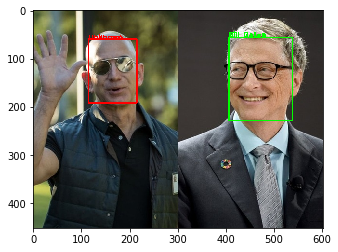

In [364]:
def plt_show(cv_img):
    img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
plt_show(img)